1. CÀI ĐẶT THƯ VIỆN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")


2. ĐỌC VÀ TIỀN XỬ LÝ DỮ LIỆU

In [5]:
data = pd.read_csv('gold_price.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.sort_values('Date') 
prices = data['Price'].str.replace(',', '').astype(float).values.reshape(-1, 1)

data

,Date,Price,Open,High,Low,Vol.,Change %
3885,2010-01-04,"1,118.30","1,099.00","1,124.60","1,093.80",155.48K,2.02%
3884,2010-01-05,"1,118.70","1,122.00","1,129.60","1,115.50",156.41K,0.04%
3883,2010-01-06,"1,136.50","1,118.50","1,141.00","1,116.80",176.90K,1.59%
3882,2010-01-07,"1,133.70","1,139.00","1,139.50","1,128.70",121.15K,-0.25%
3881,2010-01-08,"1,138.90","1,131.50","1,140.00","1,119.50",212.62K,0.46%
...,...,...,...,...,...,...,...
4,2025-03-26,"3,037.30","3,039.50","3,049.70","3,032.80",1.68K,-0.08%
3,2025-03-27,"3,075.80","3,040.90","3,086.00","3,038.90",2.86K,1.27%
2,2025-03-28,"3,114.30","3,099.30","3,124.40","3,096.30",210.49K,1.25%
1,2025-03-31,"3,150.30","3,118.80","3,162.00","3,112.40",228.39K,1.16%


3. CHUẨN HÓA DỮ LIỆU

In [6]:
scaler = StandardScaler()
scaled_prices = scaler.fit_transform(prices)

4. CHIA TẬP TRAIN VÀ TEST, VALIDATION

In [8]:
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 90
X, y = create_sequences(scaled_prices, time_steps)


# 60% train, 20% validation, 20% test
train_size = int(len(X) * 0.6)
val_size = int(len(X) * 0.2)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


Train size: 2277, Validation size: 759, Test size: 760


5. TẠO VÀ HUẤN LUYỆN MÔ HÌNH

In [9]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

FIT MÔ HÌNH VỚI DỮ LIỆU TRAIN

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.1100 - val_loss: 0.0178
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0121 - val_loss: 0.0139
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0114 - val_loss: 0.0169
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0095 - val_loss: 0.0137
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0091 - val_loss: 0.0113
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0078 - val_loss: 0.0103
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0081 - val_loss: 0.0070
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0076 - val_loss: 0.0084
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0072 - val_loss: 0.0113
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0070 - val_loss: 0.0085
Epoch 12/100


6. DỰ ĐOÁN DỮ LIỆU TEST

In [7]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inv = scaler.inverse_transform(y_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


7. ĐÁNH GIÁ MÔ HÌNH

In [ ]:
from sklearn.metrics import r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    if np.sum(non_zero) == 0:
        return np.nan
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae = mean_absolute_error(y_test_inv, y_pred)
mape = mean_absolute_percentage_error(y_test_inv, y_pred)
r2 = r2_score(y_test_inv, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


RMSE: 100.43
MAE: 66.35
MAPE: 2.68%
MASE: nan


8. DỰ ĐOÁN GIÁ VÀNG TRONG 90 NGÀY

In [11]:
# Dự báo 90 ngày tiếp theo
def forecast_future_with_details(model, last_sequence, n_future, scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    print("Dự báo 90 ngày tiếp theo:\n")
    for day in range(n_future):
      
        current_sequence_reshaped = current_sequence.reshape((1, time_steps, 1))
        
        input_prices = scaler.inverse_transform(current_sequence.reshape(-1, 1)).flatten()

        next_pred = model.predict(current_sequence_reshaped, verbose=0)
        predicted_price = scaler.inverse_transform(next_pred)[0, 0]  
        
        print(f"Ngày thứ {day + 1}:")
        print(f"Input (90 ngày trước đó): {input_prices}")
        print(f"Output (giá dự đoán): {predicted_price:.2f} USD\n")
        
        future_predictions.append(next_pred[0, 0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
    
    return scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

last_sequence = scaled_prices[-time_steps:].copy()
future_90 = forecast_future_with_details(model, last_sequence, 90, scaler)

# Chia nhỏ dự báo
future_30 = future_90[:30]
future_60 = future_90[:60]
future_90 = future_90

# Tạo danh sách ngày tương lai
future_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=90, freq='D')

Dự báo 90 ngày tiếp theo:

Ngày thứ 1:
Input (90 ngày trước đó): [2651.7 2674.9 2712.2 2618.5 2621.3 2652.3 2669.  2646.5 2655.9 2664.3
 2636.1 2647.1 2673.3 2705.6 2741.5 2695.1 2662.4 2657.  2649.6 2640.8
 2596.  2632.5 2615.5 2622.8 2640.3 2618.4 2618.1 2641.  2669.  2654.7
 2647.4 2665.4 2672.4 2690.8 2715.  2678.6 2682.3 2717.8 2750.9 2748.7
 2785.6 2797.4 2778.3 2792.7 2752.4 2781.  2781.5 2845.2 2835.  2857.1
 2875.8 2893.  2876.7 2887.6 2934.4 2932.6 2928.7 2945.4 2900.7 2949.
 2936.1 2956.1 2953.2 2949.7 2906.  2917.8 2895.9 2848.5 2901.1 2920.6
 2926.  2926.6 2914.1 2899.4 2920.9 2946.8 2991.3 3001.1 3034.1 3068.9
 3069.1 3071.3 3048.4 3044.  3039.6 3037.3 3075.8 3114.3 3150.3 3146. ]
Output (giá dự đoán): 2844.02 USD

Ngày thứ 2:
Input (90 ngày trước đó): [2674.9       2712.2       2618.5       2621.3       2652.3
 2669.        2646.5       2655.9       2664.3       2636.1
 2647.1       2673.3       2705.6       2741.5       2695.1
 2662.4       2657.        2649.6       264

9. VẼ BIỂU ĐỒ

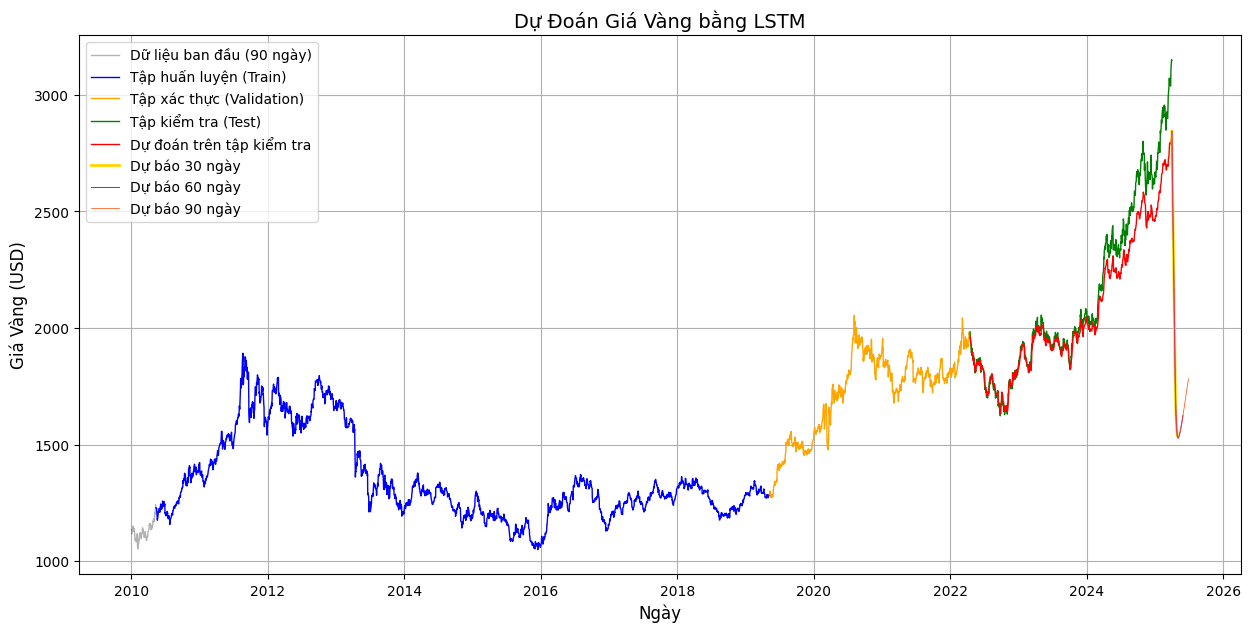

In [12]:
# Chuẩn bị dữ liệu để vẽ biểu đồ
train_dates = data['Date'][time_steps:train_size + time_steps]
val_dates = data['Date'][train_size + time_steps:train_size + val_size + time_steps]
test_dates = data['Date'][train_size + val_size + time_steps:len(data)]
train_prices = scaler.inverse_transform(scaled_prices[time_steps:train_size + time_steps])
val_prices = scaler.inverse_transform(scaled_prices[train_size + time_steps:train_size + val_size + time_steps])
test_prices = scaler.inverse_transform(scaled_prices[train_size + val_size + time_steps:])

# Vẽ biểu đồ
plt.figure(figsize=(15, 7))
plt.plot(data['Date'][:time_steps], scaler.inverse_transform(scaled_prices[:time_steps]), 'k-', label='Dữ liệu ban đầu (90 ngày)', alpha=0.3, linewidth=1.0)
plt.plot(train_dates, train_prices, 'b-', label='Tập huấn luyện (Train)', linewidth=1.0)
plt.plot(val_dates, val_prices, 'orange', label='Tập xác thực (Validation)', linewidth=1.0)
plt.plot(test_dates, test_prices, 'g-', label='Tập kiểm tra (Test)', linewidth=1.0)
plt.plot(test_dates, y_pred, 'r-', label='Dự đoán trên tập kiểm tra', linewidth=1.0)
plt.plot(future_dates[:30], future_30, color='#FFD700', label='Dự báo 30 ngày', linewidth=2.0)  
plt.plot(future_dates[:60], future_60, color='#8A2BE2', label='Dự báo 60 ngày', linewidth=0.75)  
plt.plot(future_dates, future_90, color='#FF4500', label='Dự báo 90 ngày', linewidth=0.5)  
plt.title('Dự Đoán Giá Vàng bằng LSTM', fontsize=14)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá Vàng (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()